In [1]:
import pandas as pd
import requests
import lxml.html as lh
%matplotlib inline
from pandas.io.json import json_normalize
import json
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors


# Download and clean data

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page=requests.get(url)
doc=lh.fromstring(page.content)

In [4]:
elements=doc.xpath('//tr')#table is stored in <tr>..</tr>#

In [5]:
[len(x) for x in elements[:10]] #check the length of first 10 rows#

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [6]:
list=[]
i=0
for j in elements[0]:
    i+=1
    name=j.text_content()
    print ('%d:"%s"'%(i,name))
    list.append((name,[]))

1:"Postcode"
2:"Borough"
3:"Neighbourhood
"


In [7]:
for e in range(1,len(elements)):
    T=elements[e]
    if len(T)!=3:
        break
    i=0
    for t in T.iterchildren():
        data=t.text_content()
        if i>0:
            try:
                data=int(data)
            except:
                pass
                
        list[i][1].append(data)
        i+=1

In [8]:
[len(x) for (title,x) in list]#the length of the columns#

[288, 288, 288]

In [9]:
dic={title:column for (title,column) in list}
df=pd.DataFrame(dic)

In [10]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


In [11]:
df['Neighbourhood\n'] = df['Neighbourhood\n'].map(lambda x: str(x)[:-1])

In [12]:
df.rename(columns={'Neighbourhood\n':'Neighbourhood'},inplace=True)

In [13]:
df=df[df.Borough!='Not assigned']#ignore the 'not assigned' in Borough#

In [14]:
df=df.reset_index(drop=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [15]:
df=df.groupby(['Postcode','Borough'], as_index=False).agg(','.join)# merge the Neighbourhood with the same Postcode#

In [16]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [17]:
df[df['Neighbourhood'].str.contains("Not assigned")] #sign the same value with Borough if Neighbourhood is Not assigned#

,Postcode,Borough,Neighbourhood
85,M7A,Queen's Park,Not assigned


In [18]:
df=df.replace('Not assigned','Queen"s Park')

In [19]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [20]:
df.shape

(103, 3)

# The latitude and the longitude coordinates of each neighborhood.

In [114]:
Latitude=[]
Longitude=[]
for index, row in df.iterrows():
    try:
        address=str(row['Postcode'])
        api_key = ""
        api_response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(address, api_key))
        api_response_dict = api_response.json()
        lat=api_response_dict['results'][0]['geometry']['location']['lat']
        lng=api_response_dict['results'][0]['geometry']['location']['lng']
        Latitude.append(lat)
        Longitude.append(lng)
    except Exception:
        pass
    
    
    

In [22]:
df['Latitude']=df_data_1['Latitude']
df['Longitude']=df_data_1['Longitude']

In [33]:
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Clustering neignbourhood

In [24]:
print('The number of Borough is',len(df['Borough'].unique()))
print('The number of Neighbourhood is',df['Neighbourhood'].shape[0])


The number of Borough is 11
The number of Neighbourhood is 103


In [27]:

import folium
# create map of Toronto latitude and longitude
map = folium.Map(location=[43.653908,-79.384293], zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [30]:
# utilizing the Foursquare API#
CLIENT_ID = ''
CLIENT_SECRET = '' 
VERSION = '20180605'
LIMIT=100

In [31]:
# Explore neighborhood in Downtown Toronto
def getVenues(names,latitude,longitude,radius=500):
    venues_list=[]
    for name, lat, lng in zip(names,latitude,longitude):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
       
        res=requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(name,
                             lat,
                             lng,
                             r['venue']['name'],
                             r['venue']['location']['lat'],
                             r['venue']['location']['lng'],
                             r['venue']['categories'][0]['name']) for r in res])
    venues=pd.DataFrame([j for i in venues_list for j in i])
    venues.columns=['neighborhood','neighborhood lat','neighborhood lng','venue','venue lat','venue lng','venue category']
    return venues
        

In [34]:
dt_venues=getVenues(df['Neighbourhood'],
                    df['Latitude'],df['Longitude'])

In [35]:
dt_venues.shape

(2264, 7)

In [36]:
dt_venues.head()

,neighborhood,neighborhood lat,neighborhood lng,venue,venue lat,venue lng,venue category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [37]:
dt_venues.groupby('neighborhood').count()

,neighborhood lat,neighborhood lng,venue,venue lat,venue lng,venue category
neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",3,3,3,3,3,3
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",9,9,9,9,9,9
"Alderwood,Long Branch",9,9,9,9,9,9
"Bathurst Manor,Downsview North,Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",22,22,22,22,22,22
Berczy Park,56,56,56,56,56,56


In [38]:
print('There are {} uniques categories'.format(len(dt_venues['venue category'].unique())))

There are 278 uniques categories


In [71]:
dt_venues.groupby('neighborhood').count().shape

(100, 6)

In [39]:
# Analyze each neighborhood
dt_feature=pd.get_dummies(dt_venues[['venue category']], prefix='',prefix_sep='')
dt_feature['neighborhood']=dt_venues['neighborhood']
col=dt_feature.columns.tolist()
column=col[-1:]+col[:-1]
dt_feature=dt_feature[column]
dt_feature.head()

,neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
dt_feature.shape

(2264, 279)

In [109]:
dt_group=dt_feature.groupby('neighborhood').mean().reset_index()
dt_group

,neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,...,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
1,Agincourt,0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Alderwood,Long Branch",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bathurst Manor,Downsview North,Wilson Heights",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bayview Village,0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Bedford Park,Lawrence Manor East",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.045455,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Berczy Park,0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Birch Cliff,Cliffside West",0.00,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
# Print each neighborhood with top 5 venues
num_venues=5
for i in dt_group['neighborhood']:
    print('-----'+i+'-----')
    tem=dt_group[dt_group['neighborhood']==i].T.reset_index()
    tem.columns=['venus','freq']
    tem=tem.iloc[1:]
    tem['freq']=tem['freq'].astype(float)
    tem=tem.round({'freq':2})
    tem=tem.sort_values('freq',ascending=False).reset_index(drop=True)
    print(tem.head(num_venues))
    print('\n')
    

-----Adelaide,King,Richmond-----
                 venus  freq
0          Coffee Shop  0.07
1                 Café  0.05
2  American Restaurant  0.04
3           Steakhouse  0.04
4                  Bar  0.04


-----Agincourt-----
            venus  freq
0  Clothing Store  0.25
1    Skating Rink  0.25
2  Breakfast Spot  0.25
3          Lounge  0.25
4   Movie Theater  0.00


-----Agincourt North,L'Amoreaux East,Milliken,Steeles East-----
               venus  freq
0         Playground  0.33
1                Gym  0.33
2               Park  0.33
3  Accessories Store  0.00
4  Mobile Phone Shop  0.00


-----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown-----
                 venus  freq
0        Grocery Store  0.22
1             Pharmacy  0.11
2          Pizza Place  0.11
3           Beer Store  0.11
4  Fried Chicken Joint  0.11


-----Alderwood,Long Branch-----
            venus  freq
0     Pizza Place  0.22
1        Pharmacy  0.11
2   

In [52]:
# Cluster neighborhood#
from sklearn.cluster import KMeans
k=5
dt_cluster=dt_group.drop('neighborhood',1)
model=KMeans(5,random_state=1).fit(dt_cluster)
model.labels_

array([2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 0, 4], dtype=int32)

In [48]:
Sum_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dt_cluster)
    Sum_distances.append(km.inertia_)

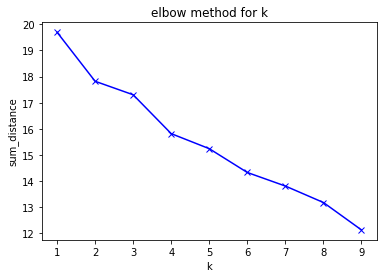

In [49]:
import matplotlib.pyplot as plt
plt.plot(K,Sum_distances,'bx-')
plt.xlabel('k')
plt.ylabel('sum_distance')
plt.title('elbow method for k')
plt.show()


In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [102]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_sorted = pd.DataFrame(columns=columns)
neighborhoods_sorted['neighborhood'] = dt_group['neighborhood']

for ind in np.arange(dt_group.shape[0]):
    neighborhoods_sorted.iloc[ind, 1:] = return_most_common_venues(dt_group.iloc[ind, :], num_top_venues)

neighborhoods_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Bar,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Bakery,Gym
1,Agincourt,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Gym,Playground,Park,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pharmacy,Fast Food Restaurant,Sandwich Place,Coffee Shop,Beer Store,Pizza Place,Fried Chicken Joint,Eastern European Restaurant,Dumpling Restaurant
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Skating Rink,Pharmacy,Pool,Pub,Sandwich Place,Gym,Airport Terminal,Department Store


In [114]:
neighborhoods_sorted.insert(0,'cluster label',model.labels_)

In [115]:
neighborhoods_sorted.head()

,cluster label,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Bar,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Bakery,Gym
1,2,Agincourt,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,0,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Gym,Playground,Park,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
3,2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pharmacy,Fast Food Restaurant,Sandwich Place,Coffee Shop,Beer Store,Pizza Place,Fried Chicken Joint,Eastern European Restaurant,Dumpling Restaurant
4,2,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Skating Rink,Pharmacy,Pool,Pub,Sandwich Place,Gym,Airport Terminal,Department Store


In [65]:
df1=df[:]
df1=df1.rename(columns={'Neighbourhood':'neighborhood'})
df1.head()

,Postcode,Borough,neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [116]:
df_total=pd.merge(df1,neighborhoods_sorted)
df_total.head()

,Postcode,Borough,neighborhood,Latitude,Longitude,cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,2,Fast Food Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2,Bar,Yoga Studio,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Dim Sum Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,2,Electronics Store,Spa,Pizza Place,Breakfast Spot,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Yoga Studio,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,Coffee Shop,Korean Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Diner,Dive Bar,Dog Run


In [117]:
df_total.shape

(100, 16)

In [78]:
# visualize the resulting clusters
map_clusters = folium.Map(location=[43.653908,-79.384293], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_total['Latitude'], df_total['Longitude'], df_total['neighborhood'], df_total['cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [92]:
dt_venues['venue category'].value_counts()


Coffee Shop                      187
Café                              97
Pizza Place                       58
Restaurant                        57
Park                              57
Bakery                            53
Italian Restaurant                48
Bar                               44
Hotel                             43
Sandwich Place                    41
Japanese Restaurant               40
Fast Food Restaurant              39
Clothing Store                    32
Gym                               32
American Restaurant               30
Grocery Store                     27
Breakfast Spot                    26
Sushi Restaurant                  26
Gastropub                         25
Burger Joint                      24
Chinese Restaurant                24
Thai Restaurant                   24
Seafood Restaurant                24
Pub                               23
Steakhouse                        22
Vegetarian / Vegan Restaurant     21
Pharmacy                          20
D

# Cluster 1 ( Trail, Park, Restaurant)

In [153]:

df_total.loc[df_total['cluster label']==0,df_total.columns[[2]+[i for i in range(6,16)]]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Clairlea,Golden Mile,Oakridge",Bus Line,Bakery,Soccer Field,Bus Station,Metro Station,Fast Food Restaurant,Park,Empanada Restaurant,Electronics Store,Eastern European Restaurant
14,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Gym,Playground,Park,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
23,Parkwoods,Fast Food Restaurant,Bus Stop,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Discount Store,Dive Bar,Dog Run,Doner Restaurant
29,Downsview West,Grocery Store,Shopping Mall,Hotel,Park,Bank,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
34,Woodbine Heights,Pharmacy,Park,Dance Studio,Beer Store,Skating Rink,Asian Restaurant,Cosmetics Shop,Curling Ice,Donut Shop,Dive Bar
38,East Toronto,Park,Pizza Place,Coffee Shop,Convenience Store,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run
42,Lawrence Park,Lake,Park,Swim School,Bus Line,Donut Shop,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Yoga Studio
43,Davisville North,Gym,Park,Sandwich Place,Breakfast Spot,Clothing Store,Food & Drink Shop,Hotel,Yoga Studio,Doner Restaurant,Discount Store
48,Rosedale,Park,Playground,Building,Trail,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run
62,"Forest Hill North,Forest Hill West",Trail,Park,Sushi Restaurant,Bus Line,Jewelry Store,Yoga Studio,Discount Store,Dive Bar,Dog Run,Doner Restaurant


# Cluster 2 (Garden, Drugstore, Restaurant)

In [154]:
df_total.loc[df_total['cluster label']==1,df_total.columns[[2]+[i for i in range(6,16)]]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Roselawn,Garden,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Dessert Shop


# Cluster 3 ( Coffee shop, Restaurant, Park)

In [155]:
df_total.loc[df_total['cluster label']==2,df_total.columns[[2]+[i for i in range(6,16)]]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge,Malvern",Fast Food Restaurant,Yoga Studio,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,"Highland Creek,Rouge Hill,Port Union",Bar,Yoga Studio,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Dim Sum Restaurant
2,"Guildwood,Morningside,West Hill",Electronics Store,Spa,Pizza Place,Breakfast Spot,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Yoga Studio,Dog Run
3,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
4,Cedarbrae,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Diner,Dive Bar,Dog Run
5,Scarborough Village,Women's Store,Health & Beauty Service,Playground,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
6,"East Birchmount Park,Ionview,Kennedy Park",Department Store,Playground,Coffee Shop,Discount Store,Donut Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant
8,"Cliffcrest,Cliffside,Scarborough Village West",American Restaurant,Motel,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
9,"Birch Cliff,Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Comic Shop,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
10,"Dorset Park,Scarborough Town Centre,Wexford He...",Indian Restaurant,Pet Store,Gaming Cafe,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Dog Run,Dim Sum Restaurant,Diner,Discount Store


# Cluster 4 ( Cafeteria, Yoga Studio, Restaurant)

In [156]:
df_total.loc[df_total['cluster label']==3,df_total.columns[[2]+[i for i in range(6,16)]]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"Silver Hills,York Mills",Cafeteria,Yoga Studio,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


# Cluster 5 ( Park, Airport, Bank)

In [157]:
df_total.loc[df_total['cluster label']==4,df_total.columns[[2]+[i for i in range(6,16)]]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,York Mills West,Park,Bank,Convenience Store,Yoga Studio,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
28,"CFB Toronto,Downsview East",Airport,Park,Yoga Studio,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
88,"The Kingsway,Montgomery Road,Old Mill North",Park,River,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
95,Weston,Park,Yoga Studio,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
